# Zillow Project
### - By Jeff Akins

In [1]:
# Imports:
import zillow_wrangle as zw
import explore_evaluate as ee
import zillow_models as zm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

import warnings
warnings.filterwarnings("ignore")

### Acquire
- I created a series of functions to acquire and clean the zillow data, which are located in the zillow_wrangle.py file. They take in all of the single unit properties (code 261 from the propertylandusetypeid column on the properties_2017 table in the zillow data set) that were sold between 1 May and 1 Sept of 2017 (based on the predictions_2017 table) into a Pandas dataFrame. 
- Top and Bottom 20% of outliers were removed.
- I then add on a column for zipcodes and average home price per zipcode, as well as the county and sate name based on the FIPS code. 

In [2]:
zillow = zw.wrangle_zillow()
zillow.head(3)

,bedrooms,bathrooms,sqft,tax_value,year_built,tax_amount,fips,zipcode,zipcode_avg_price,county,state
0,3,2.0,1772,418763.0,1978,4464.42,6111,97089,408141,Ventura County,CA
1,4,2.0,1896,94711.0,1957,1017.10,6111,97089,408141,Ventura County,CA
2,5,4.5,3980,769907.0,1999,8650.36,6111,97089,408141,Ventura County,CA


In [3]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27363 entries, 0 to 27362
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           27363 non-null  int64  
 1   bathrooms          27363 non-null  float64
 2   sqft               27363 non-null  int64  
 3   tax_value          27363 non-null  float64
 4   year_built         27363 non-null  int64  
 5   tax_amount         27363 non-null  float64
 6   fips               27363 non-null  int64  
 7   zipcode            27363 non-null  int64  
 8   zipcode_avg_price  27363 non-null  int64  
 9   county             27363 non-null  object 
 10  state              27363 non-null  object 
dtypes: float64(3), int64(6), object(2)
memory usage: 2.5+ MB


In [4]:
# Dropping uneeded columns for regression analysis
zillow = zillow.drop(columns=['year_built', 'tax_amount', 'fips', 'zipcode', 'county', 'state'])
zillow.head(2)

,bedrooms,bathrooms,sqft,tax_value,zipcode_avg_price
0,3,2.0,1772,418763.0,408141
1,4,2.0,1896,94711.0,408141


### Initial Plots

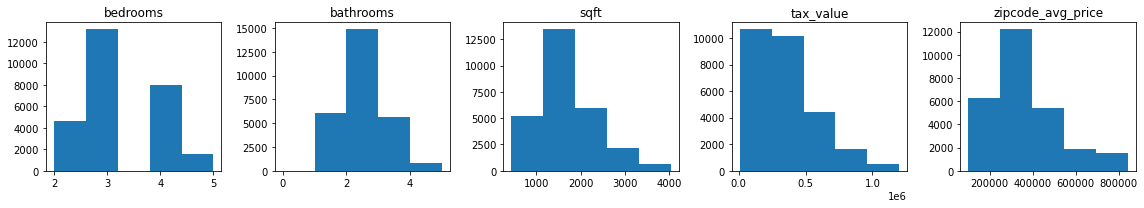

In [5]:
zw.zillow_subplots(zillow)

<Figure size 648x432 with 0 Axes>

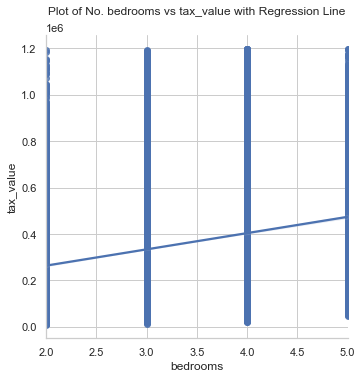

In [6]:
zw.initial_plot(zillow, 'bedrooms', 'tax_value')

<Figure size 648x432 with 0 Axes>

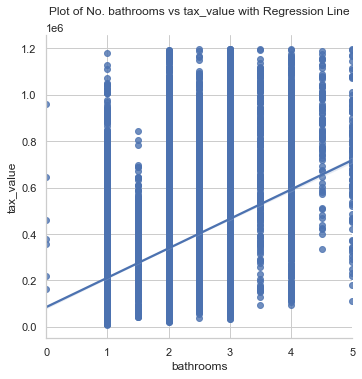

In [7]:
zw.initial_plot(zillow, 'bathrooms', 'tax_value')

<Figure size 648x432 with 0 Axes>

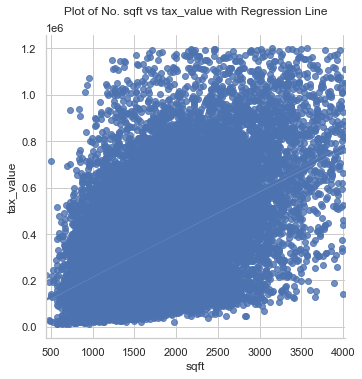

In [8]:
zw.initial_plot(zillow, 'sqft', 'tax_value')

<Figure size 648x432 with 0 Axes>

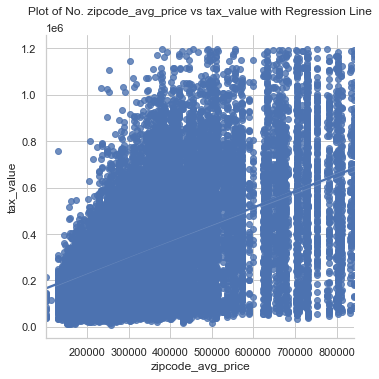

In [9]:
zw.initial_plot(zillow, 'zipcode_avg_price', 'tax_value')

#### Findings:
- It appears that there are linear relationships between the target and bedrooms, bathrooms, sqft, and average price per zipcode

### Scaling
- I then scale the data using a min-max scalar and drop any colums that I do not plan to use.
- List of Columns that are scaled:
 - bedrooms
 - bathrooms
 - sqft
 - zipcode_avg_price

In [10]:
# First split into train, validate, test
train, validate, test = zw.train_validate_test_split(zillow, seed=123)
print('Train shape: ', train.shape)
print('Validate shape: ', validate.shape)
print('Test shape: ', test.shape)

Train shape:  (15391, 5)
Validate shape:  (5131, 5)
Test shape:  (6841, 5)


In [11]:
# Scale the data using a min max scaler  
train, validate, test = zw.zillow_scaler(train, validate, test)
train.head(2)

,bedrooms,bathrooms,sqft,tax_value,zipcode_avg_price
26386,0.666667,0.7,0.622556,370267.0,0.422078
17547,0.000000,0.2,0.169170,195790.0,0.178563


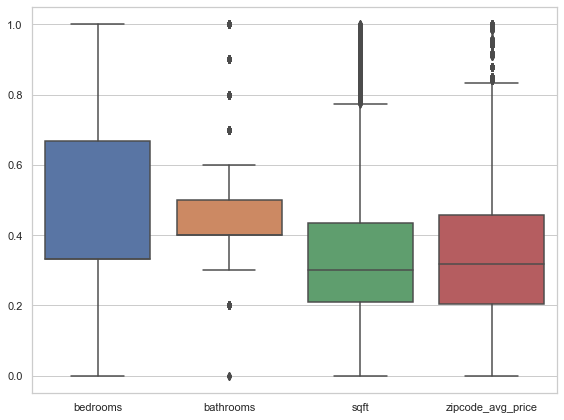

In [12]:
# Boxplot to show the distributions for train:
plt.figure(figsize=(8,6))
sns.boxplot(data=train.drop(columns='tax_value'))
plt.tight_layout()
plt.show()

### Explore

In [13]:
train_corr = train.corr()
train_corr

,bedrooms,bathrooms,sqft,tax_value,zipcode_avg_price
bedrooms,1.000000,0.600456,0.605017,0.249542,0.139372
bathrooms,0.600456,1.000000,0.783215,0.422510,0.313088
sqft,0.605017,0.783215,1.000000,0.512572,0.385193
tax_value,0.249542,0.422510,0.512572,1.000000,0.469863
zipcode_avg_price,0.139372,0.313088,0.385193,0.469863,1.000000


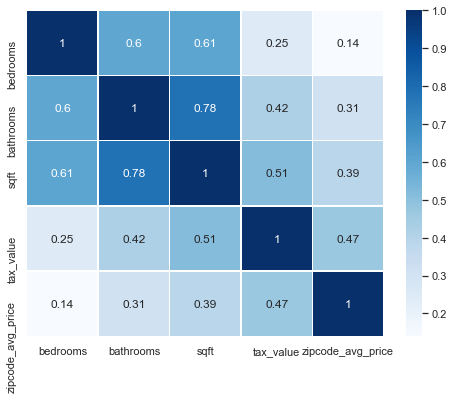

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(train_corr, cmap='Blues', annot=True, linewidth=0.5)
plt.show()

##### Based on the correlation heatmap, I will run statistical tests on all categories
- H0: There is no correlation between beadrooms, bathrooms, squarefootage, average home price per zipcode and home price
- Ha: There is a correlation between beadrooms, bathrooms, squarefootage, average home price per zipcode and home price

In [15]:
# Function that will run spearman r and pearson r statistical tests on all four categories
# H0: There is no correlation between beadrooms, bathrooms, squarefootage, average home price per zipcode and home price
ee.correlation_table(train)

,spearmanr_corr,spearmanr_p,pearsonr_corr,pearsonr_p
bedrooms,0.244154,1.082276e-207,0.249542,3.620870e-217
bathrooms,0.399758,0.000000e+00,0.422510,0.000000e+00
sqft,0.451775,0.000000e+00,0.512572,0.000000e+00
zipcode_avg_price,0.455077,0.000000e+00,0.469863,0.000000e+00


##### Findings:
- Based on the above table, we can reject the null hypothisis.
- We can conclude that there is a correlation between beadrooms, bathrooms, squarefootage, average home price per zipcode and home price

### Feature Engineer

In [16]:
# First we need to separate the target:
X_train, y_train, X_validate, y_validate, X_test, y_test = zw.zillow_xy(train, validate, test)

In [17]:
# This function will produce a list of the best features for modeling
ee.rfe_output(X_train, y_train)

,Var,Rank
0,bedrooms,4
1,bathrooms,3
2,sqft,1
3,zipcode_avg_price,2


### Model

### Evaluate